本notebook主要实现从训练好的模型渲染rgb

#必做项

搭载Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/MyDrive/NeuralRecon-W-test"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['metrics.py',
 'README.md',
 'LICENSE',
 'losses.py',
 'environment.yaml',
 'scripts',
 'models',
 'evaluations',
 'assets',
 'rendering',
 'opt.py',
 'lightning_modules',
 'datasets',
 '.gitignore',
 'data',
 'weights',
 'log',
 'config',
 'logs',
 '__pycache__',
 'results',
 'requirements.txt',
 'kaolin',
 'checkpoints',
 'ckpts',
 'tools',
 'utils',
 'train.py',
 '\\']

# 基础操作

##查看GPU信息

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

##Restart Runtime

In [ ]:
import os
os.kill(os.getpid(), 9)

# 依赖包安装

In [2]:
!pip install torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
!pip install open3d==0.12.0
!pip install kornia==0.4.1
!pip install loguru
!pip install torch_optimizer
!pip install trimesh==3.9.1
!pip install cython==0.29.20
!pip install lpips==0.1.3
!pip install torchmetrics==0.7.0
!pip install yacs
!pip install test-tube==0.7.5
!pip install tornado==5.1.0
#%pip install git+https://github.com/cpfy/lightning
%pip install git+https://github.com/cpfy/lightning@v1.4.8_origin

import os
path="/content/drive/MyDrive/NeuralRecon-W-test/kaolin"
os.chdir(path)
%env IGNORE_TORCH_VER=1
!python setup.py develop
path="/content/drive/MyDrive/NeuralRecon-W-test"
os.chdir(path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 188.4 MB 41 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 225 kB 32.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 7.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 621 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 628 kB 26.8 MB/s 
Looking in indexes: https://pypi.org/simple, https:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cpfy/lightning (to revision v1.4.8_origin) to /tmp/pip-req-build-gmp_ehfb
  Running command git clone -q https://github.com/cpfy/lightning /tmp/pip-req-build-gmp_ehfb
  Running command git checkout -b v1.4.8_origin --track origin/v1.4.8_origin
  Switched to a new branch 'v1.4.8_origin'
  Branch 'v1.4.8_origin' set up to track remote branch 'v1.4.8_origin' from 'origin'.
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 829 kB 35.8 MB/s 
     |████████████████████████████████| 141 kB 63.3 MB/s 
     |████████████████████████████████| 596 kB 67.2 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.4.8-py3-none-any.whl size=924069 sha256=fe8fb085ae12a7d4a7a17016254052

# 数据准备与训练

略，这里是nerf_pl nerfw的

In [ ]:
!python prepare_phototourism.py --root_dir /home/ubuntu/data/IMC-PT/brandenburg_gate/ --img_downscale 8

!python train.py \
  --root_dir /home/ubuntu/data/IMC-PT/brandenburg_gate/ --dataset_name phototourism \
  --img_downscale 8 --use_cache \
  --N_importance 64 --N_samples 64 --encode_a --encode_t --beta_min 0.03 --N_vocab 1500 --N_emb_xyz 15 \
  --num_epochs 20 --batch_size 1024 \
  --optimizer adam --lr 5e-4 --lr_scheduler cosine \
  --exp_name brandenburg_scale8_nerfw

#Evaluating

选择ckpt生成图像+评估（!python 运行文件）【nerf_pl原做法】

之后章节为效果复现(in .ipynb)



In [ ]:
!python eval.py \
  --root_dir ../NeuralRecon-W-test/data/heritage-recon/brandenburg_gate \
  --dataset_name phototourism --scene_name brandenburg_test \
  --split test --N_samples 256 --N_importance 256 \
  --N_vocab 1500 --encode_a --encode_t \
  --ckpt_path ckpts/scale2_epoch.29.ckpt \
  --chunk 16384 --img_wh 320 240

# 此处直接白嫖NeuralReconW的数据集

100% 120/120 [36:33<00:00, 18.28s/it]


## 初始加载

In [2]:
import torch
from utils import load_ckpt, visualize_depth  # 与nerf_pl基本一样的，参数略有变化
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from rendering.renderer import *
from models.nerf import *
from models.neuconw import *  #新增neuconw模型

import metrics

from datasets import dataset_dict

torch.backends.cudnn.benchmark = True

此处把eval中的dataset等参数都加载到ipynb中来（此步较慢，一般近2min）

In [3]:
dataset = dataset_dict['phototourism'] \
          ('data/heritage-recon/brandenburg_gate/',
           split='test_train',
           img_downscale=5, use_cache=False)

#使用了与BG训练一致的img_downscale=5参数

reading sfm result from ../neuralsfm...
Reading images.bin..
Reading cameras.bin..
Compute c2w poses..


搬运defaults.py中的模型各个Net参数

In [4]:
# from matplotlib.colors import BoundaryNorm
from yacs.config import CfgNode as CN

# defaults.py文件均用于全部参数配置
# CN容器装载参数，管理配置，也可读写yaml用
_CN = CN()


_CN.NEUCONW = CN()


# network config
# 第一个SDF的Net参数：d=\text{MLP}_{\text{SDF}}(x)
_CN.NEUCONW.SDF_CONFIG = CN()           # CN()容器的嵌套，外面直接调用config.NEUCONW.SDF_CONFIG
_CN.NEUCONW.SDF_CONFIG.d_in = 3         # 输入仅为x的三维坐标xyz，因此in=3
_CN.NEUCONW.SDF_CONFIG.d_out = 513
_CN.NEUCONW.SDF_CONFIG.d_hidden = 512
_CN.NEUCONW.SDF_CONFIG.n_layers = 8
_CN.NEUCONW.SDF_CONFIG.skip_in = (4,)   # 依然保留第[4]层的skip connection
_CN.NEUCONW.SDF_CONFIG.multires = 6
_CN.NEUCONW.SDF_CONFIG.bias = 0.5
_CN.NEUCONW.SDF_CONFIG.scale = 1
_CN.NEUCONW.SDF_CONFIG.geometric_init = True
_CN.NEUCONW.SDF_CONFIG.weight_norm = True
_CN.NEUCONW.SDF_CONFIG.inside_outside = False

# 第一个司掌Color的Net参数
_CN.NEUCONW.COLOR_CONFIG = CN()
_CN.NEUCONW.COLOR_CONFIG.d_in = 9
_CN.NEUCONW.COLOR_CONFIG.d_feature = 512
_CN.NEUCONW.COLOR_CONFIG.mode = "idr"
_CN.NEUCONW.COLOR_CONFIG.d_out = 3
_CN.NEUCONW.COLOR_CONFIG.d_hidden = 256 
_CN.NEUCONW.COLOR_CONFIG.n_layers = 4
_CN.NEUCONW.COLOR_CONFIG.head_channels = 128
_CN.NEUCONW.COLOR_CONFIG.static_head_layers = 2
_CN.NEUCONW.COLOR_CONFIG.weight_norm = True
_CN.NEUCONW.COLOR_CONFIG.multires_view = 4

_CN.NEUCONW.S_CONFIG = CN()
_CN.NEUCONW.S_CONFIG.init_val = 0.03

初始化参数，加载模型

In [5]:
# Change to your settings...
############################
N_vocab = 5000  # pl原值为1500，neuconw使用5000作为参数
encode_appearance = True
N_a = 48
beta_min = 0.03 # doesn't have effect in testing
ckpt_path = 'checkpoints/train-exp_BG-20220812_0039/iter_650000.ckpt'

# 删去encode_transient、inchannels_t等与transient encoding相关的参数


N_emb_xyz = 10  # 默认值15，但和ckpt不匹配
N_emb_dir = 4
N_samples = 128
N_importance = 128
use_disp = False
chunk = 1024*32
#############################

embedding_xyz = PosEmbedding(N_emb_xyz-1, N_emb_xyz)
embedding_dir = PosEmbedding(N_emb_dir-1, N_emb_dir)
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}
if encode_appearance:
    embedding_a = torch.nn.Embedding(N_vocab, N_a).cuda()
    load_ckpt(embedding_a, ckpt_path, model_name='embedding_a')
    embeddings['a'] = embedding_a
    

# neuconW模型定义参见neuconw.py line 84，用同样方式加载出来
# 摘录如下：
# self.neuconw = NeuconW(
#             sdfNet_config=self.config.NEUCONW.SDF_CONFIG,       # 控制符号距离函数Net，相当于NeRFW中的\theta_1
#             colorNet_config=self.config.NEUCONW.COLOR_CONFIG,   # 控制颜色Net，相当于NeRFW中的\theta_2
#             SNet_config=self.config.NEUCONW.S_CONFIG,           # todo 第3个Net，用于？相当于NeRFW中的\theta_3
#             in_channels_a=self.config.NEUCONW.N_A,              # =48
#             encode_a=self.config.NEUCONW.ENCODE_A,
#         )

neuconw = NeuconW(  sdfNet_config=_CN.NEUCONW.SDF_CONFIG,       # 控制符号距离函数Net，相当于NeRFW中的\theta_1
            colorNet_config=_CN.NEUCONW.COLOR_CONFIG,   # 控制颜色Net，相当于NeRFW中的\theta_2
            SNet_config=_CN.NEUCONW.S_CONFIG,           # todo 第3个Net，用于？相当于NeRFW中的\theta_3
            in_channels_a=48,
            encode_a=True).cuda()

# nerf_coarse = NeRF('coarse',
#               in_channels_xyz=6*N_emb_xyz+3,
#               in_channels_dir=6*N_emb_dir+3).cuda()
# nerf_fine = NeRF('fine',
#               in_channels_xyz=6*N_emb_xyz+3,
#               in_channels_dir=6*N_emb_dir+3,
#               encode_appearance=encode_appearance,
#               in_channels_a=N_a,
#               beta_min=beta_min).cuda()

load_ckpt(neuconw, ckpt_path, model_name='nerf_coarse',strict=False)  # strict表示忽略unexpected_keys或者missing_keys

models = {'coarse': neuconw, 'fine': neuconw}

批处理推断函数（in nerf_pl-nerfw）

In [ ]:
@torch.no_grad()
def f(rays, ts, **kwargs):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    results = defaultdict(list)
    for i in range(0, B, chunk):
        kwargs_ = {}
        if 'a_embedded' in kwargs:
            kwargs_['a_embedded'] = kwargs['a_embedded'][i:i+chunk]
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        ts[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True,
                        **kwargs_)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

加入Renderer

In [ ]:
from rendering.renderer import NeuconWRenderer

self.renderer = NeuconWRenderer(
            nerf=self.nerf,
            neuconw=self.neuconw,
            embeddings=self.embeddings,
            n_samples=self.config.NEUCONW.N_SAMPLES,
            s_val_base=self.config.NEUCONW.S_VAL_BASE,
            n_importance=self.config.NEUCONW.N_IMPORTANCE,
            n_outside=self.config.NEUCONW.N_OUTSIDE,
            up_sample_steps=self.config.NEUCONW.UP_SAMPLE_STEP,
            perturb=1.0,
            origin=self.scene_config["origin"],
            radius=self.scene_config["radius"],
            render_bg=self.config.NEUCONW.RENDER_BG,
            mesh_mask_list=self.config.NEUCONW.MESH_MASK_LIST,
            floor_normal=self.config.NEUCONW.FLOOR_NORMAL,
            floor_labels=self.config.NEUCONW.FLOOR_LABELS,
            depth_loss=self.config.NEUCONW.DEPTH_LOSS,
            spc_options=spc_options,
            sample_range=self.config.NEUCONW.SAMPLE_RANGE,
            boundary_samples=self.config.NEUCONW.BOUNDARY_SAMPLES,
            nerf_far_override=self.config.NEUCONW.NEAR_FAR_OVERRIDE,
        )

neuconw的forward函数改写

In [7]:
from collections import defaultdict

# 本函数基于nerf_pl中的eval.py的batched_inference改写，原函数using chunk
@torch.no_grad()
def f(rays, ts, label):
    """Do batched inference on rays"""
    results = defaultdict(list)

    # render中仅封装了fine的结果，未使用coarse
    rendered_ray_chunks = self.renderer.render(
        rays,
        ts,
        label,
        background_rgb=torch.zeros([1, 3], device=rays.device),
        cos_anneal_ratio=self.get_cos_anneal_ratio(),
    )

    for k, v in rendered_ray_chunks.items():
        results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, dim=0)

    return results

## 获取单图推断结果

只需4行，十分简单。大约需要10-25s

In [8]:
# 默认参数5，实际随便取，就是图像编号id
sample = dataset[51]
rays = sample['rays'].cuda()
ts = sample['ts'].cuda()

results = f(rays, ts, "building")

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


【Output】image path id is 62
【Output】image name is 04800984_8342094434


FileNotFoundError: ignored

绘制可视化

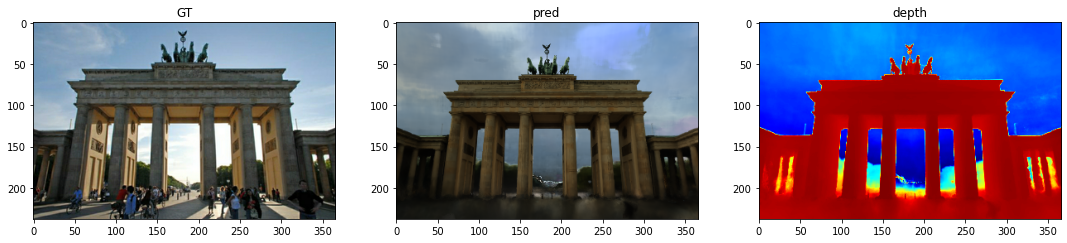

PSNR between GT and pred: 12.022077560424805 

Decomposition-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


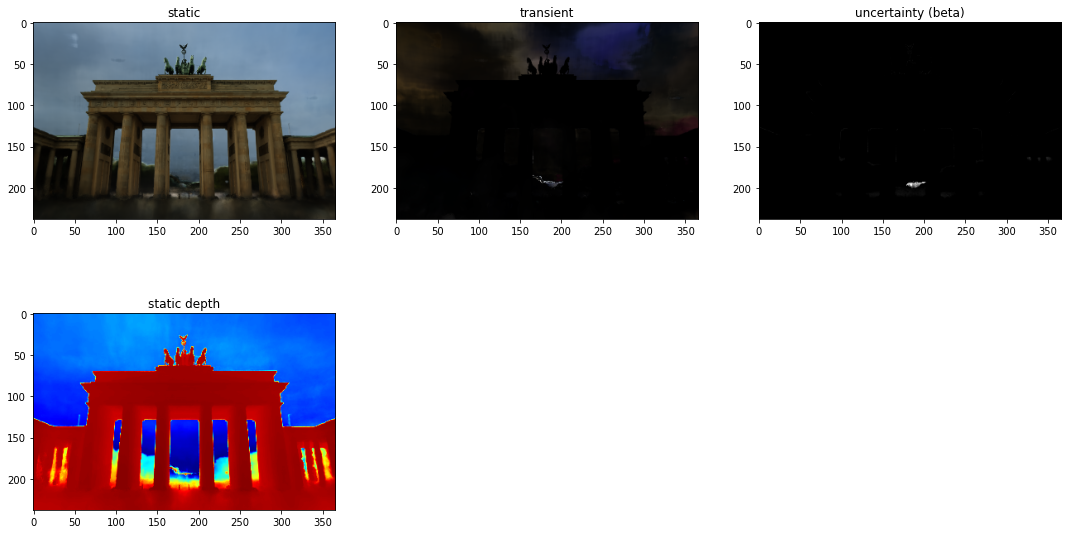

In [ ]:
img_wh = tuple(sample['img_wh'].numpy())
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(231)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(232)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(233)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

print('PSNR between GT and pred:', metrics.psnr(img_gt, img_pred).item(), '\n')


if encode_transient:
    print('Decomposition--------------------------------------------' + 
          '---------------------------------------------------------' +
          '---------------------------------------------------------' + 
          '---------------------------------------------------------')
    beta = results['beta'].view(img_wh[1], img_wh[0]).cpu().numpy()
    img_pred_static = results['rgb_fine_static'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    img_pred_transient = results['_rgb_fine_transient'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
    depth_pred_static = results['depth_fine_static'].view(img_wh[1], img_wh[0])
    depth_pred_transient = results['depth_fine_transient'].view(img_wh[1], img_wh[0])
    plt.subplots(figsize=(15, 8))
    plt.tight_layout()
    plt.subplot(231)
    plt.title('static')
    plt.imshow(img_pred_static)
    plt.subplot(232)
    plt.title('transient')
    plt.imshow(img_pred_transient)
    plt.subplot(233)
    plt.title('uncertainty (beta)')
    plt.imshow(beta-beta_min, cmap='gray')
    plt.subplot(234)
    plt.title('static depth')
    plt.imshow(visualize_depth(depth_pred_static).permute(1,2,0))
    plt.show()

## appearance插值

设定左右样本及插值个数，因为需要生成多个结果（约2min）

使用右样本的pose，插值样本的外观编码

In [ ]:
left_sample = dataset[54]   # defaults:53
right_sample = dataset[121] # defaults:111

right_rays = right_sample['rays'].cuda()
right_ts = right_sample['ts'].cuda()
left_a_embedded = embedding_a(left_sample['ts'][0].cuda())
right_a_embedded = embedding_a(right_sample['ts'].cuda())

results_list = [left_sample]

for i in range(5):
    kwargs = {'a_embedded': right_a_embedded*i/4+left_a_embedded*(1-i/4)}
    results_list += [f(right_rays, right_ts, **kwargs)]

results_list += [right_sample]

效果绘制，说实话除了论文里的样例其它效果挺差的

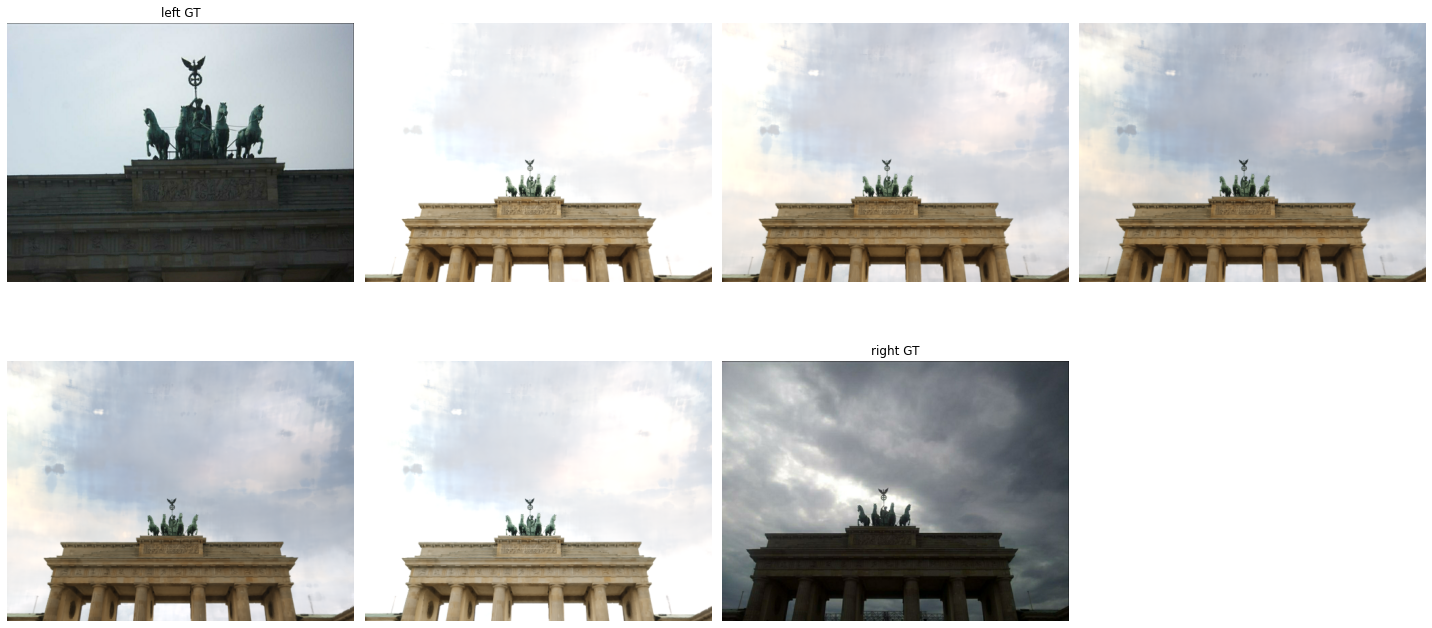

In [ ]:
plt.subplots(figsize=(20, 10))
for i, results in enumerate(results_list):
    if i == 0:
        img_wh = tuple(results['img_wh'].numpy())
        left_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(241)
        plt.axis('off')
        plt.title('left GT')
        plt.imshow(left_GT)
    elif i == 6:
        img_wh = tuple(results['img_wh'].numpy())
        right_GT = results['rgbs'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(247)
        plt.axis('off')
        plt.title('right GT')
        plt.imshow(right_GT)
    else:
        img_wh = tuple(right_sample['img_wh'].numpy())
        img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
        plt.subplot(2, 4, i+1)
        plt.axis('off')
        plt.imshow(img_pred)
plt.tight_layout()
plt.show()